# PyCaret to Compare Performance by Models

### SeungHeon Han

In [1]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import copy
from collections import Counter
from numpy import where
import statsmodels.api as sm
from pycaret.classification import * 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
import random
import itertools
from imblearn import over_sampling
from imblearn import under_sampling
from imblearn.pipeline import Pipeline
import os              # for directory and file manipulation
import numpy as np     # for basic array manipulation
import pandas as pd    # for dataframe manipulation
import datetime        # for timestamp
from sklearn.metrics import accuracy_score, f1_score, log_loss, mean_squared_error, roc_auc_score, roc_curve


# global constants 
ROUND = 3              # generally, insane precision is not needed 

# set global random seed for better reproducibility
SEED = 1234
seed = 1234
np.random.seed(SEED)
NTHREAD = 4

import warnings
warnings.filterwarnings('ignore')

In [4]:
# import the cleaned dataset 
%cd /Users/alex/Desktop/Master/BA_Practicum_6217_10/Project/dataset/partB
partB = pd.read_csv("processed_partB.csv")

/Users/alex/Desktop/Master/BA_Practicum_6217_10/Project/dataset/partB


In [5]:
partB = partB.drop("Avg_Mdcr_Stdzd_Amt", axis=1)
partB.head()

,NPI,Type,Place_Of_Srvc,Tot_Benes,Tot_Srvcs,Tot_Bene_Day_Srvcs,Avg_Sbmtd_Chrg,Avg_Mdcr_Alowd_Amt,Avg_Mdcr_Pymt_Amt,Fraud
0,1679548440,Dermatology,O,25,46.0,46,281.000000,128.275435,100.793043,0
1,1184730848,Podiatry,O,15,19.0,19,18.962105,18.571579,13.215263,0
2,1700097557,Diagnostic Radiology,F,32,32.0,32,27.000000,9.387187,7.243750,0
3,1659528339,Mass Immunizer Roster Biller,O,112,114.0,114,4.940614,4.366404,4.366404,0
4,1982966685,Family Practice,O,112,114.0,114,35.000000,25.290000,25.290000,0


### Ratio of Fraud and Non-fraud classes 

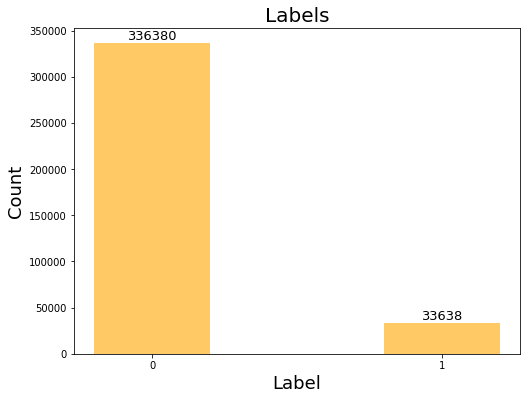

In [ ]:
fig = plt.figure(figsize=(8, 6))

# Plot the bar graph
Y_fraud = list(partB["Fraud"].value_counts())
X_fraud = ["0", "1"]

plot = plt.bar(X_fraud, Y_fraud, 
               width = 0.4,
              color = "orange",
              alpha = 0.6)
 
# Add the data value on head of the bar
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%d' % int(height), ha='center', va='bottom', 
             fontsize = 13)
 
# Add labels and title
plt.title("Labels", fontsize = 20)
plt.xlabel("Label", fontsize = 18)
plt.ylabel("Count", fontsize = 18)
 
# Display the graph on the screen
plt.show()

In [ ]:
ratio = partB["Fraud"].value_counts(normalize = True) 
print("Non-Fraud: ", round(ratio[0]*100, 2), "%")
print("Fraud: ", round(ratio[1]*100, 2), "%")

Non-Fraud:  90.91 %
Fraud:  9.09 %


### Data Spliting

In [6]:
# Assign X and y features

X_var = list(partB.columns)

for var in ["NPI","Fraud"]:
    X_var.remove(var)

y_var = "Fraud"

In [7]:
# Split the whole dataset into train and test dataset
# Using a stratified random sampling so that the Fraud-class (1) data are evenly split into train & test sets
x_train, x_test, y_train, y_test = train_test_split(partB[X_var], 
                                                    partB[y_var], 
                                                    test_size=0.1, 
                                                    stratify=partB["Fraud"],
                                                    random_state=SEED)

# Also concatenate the split x & y dataframes 
tr_df = pd.concat([x_train, y_train], axis = 1)
te_df = pd.concat([x_test, y_test], axis = 1)

In [8]:
# Calculate the odds ratio of Fraud & Non-fraud labels for train & test sets

train_0 = len(tr_df[tr_df["Fraud"] == 0])
train_1 = len(tr_df[tr_df["Fraud"] == 1])

test_0 = len(te_df[te_df["Fraud"] == 0])
test_1 = len(te_df[te_df["Fraud"] == 1])

split_df = pd.DataFrame({"x_axis":["Train", "Test"], 
                         "Ratio":[train_1/train_0, test_1/test_0]})

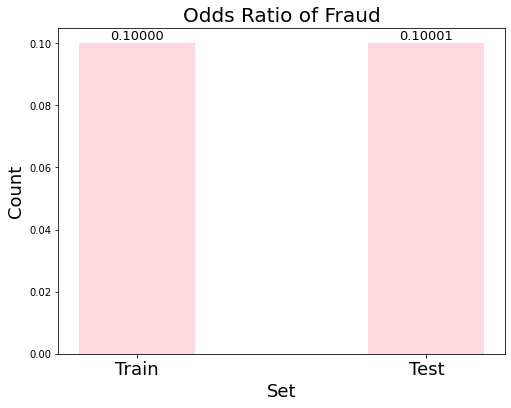

In [9]:
fig, ax = plt.subplots(figsize=(8,6))

# Plot the bar graph
plot = plt.bar(split_df["x_axis"], split_df["Ratio"],
               width = 0.4,
              color = "pink",
              alpha = 0.6)
 
# Add the data value on head of the bar
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%.5f' % height, ha='center', va='bottom', 
             fontsize = 13)
 
# Add labels and title
plt.title("Odds Ratio of Fraud", fontsize = 20)
plt.xlabel("Set", fontsize = 18)
plt.ylabel("Count", fontsize = 18)

ax.set_xticklabels(split_df["x_axis"], fontsize=18)

# Display the graph on the screen
plt.show()

### -----------------SMOTE---------------------

In [ ]:
tr_df.head()

,Tot_Benes,Tot_Srvcs,Tot_Bene_Day_Srvcs,Avg_Sbmtd_Chrg,Avg_Mdcr_Alowd_Amt,Avg_Mdcr_Pymt_Amt,Type_Advanced Heart Failure and Transplant Cardiology,Type_All Other Suppliers,Type_Allergy/ Immunology,Type_Allergy/Immunology,...,Type_Thoracic Surgery,Type_Undefined Physician type,Type_Undersea and Hyperbaric Medicine,Type_Unknown Physician Specialty Code,Type_Unknown Supplier/Provider,Type_Unknown Supplier/Provider Specialty,Type_Urology,Type_Vascular Surgery,Place_Of_Srvc,Fraud
348797,12,12.0,12,66.000000,30.146667,24.017500,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
33489,32,51.0,51,140.000000,53.551373,38.991765,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
70149,22,69.0,69,100.000000,69.400725,53.272464,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
151709,40,50.0,50,30.000000,15.430000,15.430000,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
84786,61,62.0,62,213.629032,120.259032,65.797581,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Scatter Plot of The Imbalanced Data

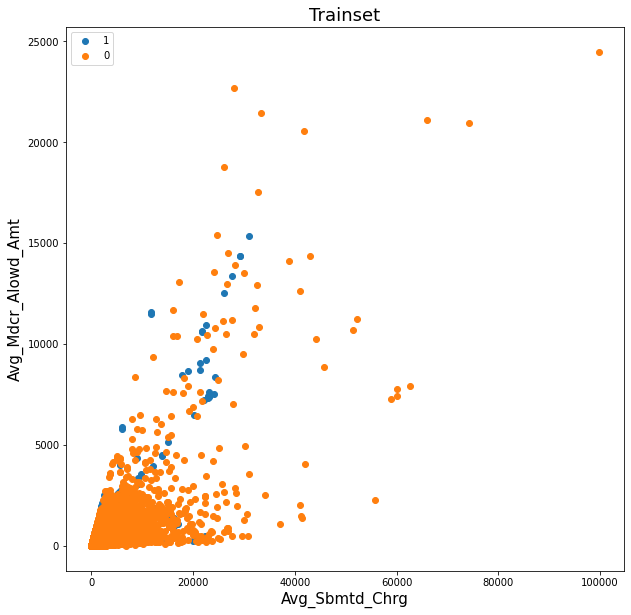

In [ ]:
# scatter plot of the imbalanced data
# x-axis = "Tot_Benes_mean"
# y-axis = "Tot_Bene_Day_Srvcs_mean"

plt.figure(figsize=(10, 10))

counter = Counter(tr_df[y_var])
for label, _ in counter.items():
    row_ix = where(tr_df[y_var] == label)[0]
    plt.scatter(tr_df[X_var].iloc[row_ix, 3], 
                tr_df[X_var].iloc[row_ix, 4], 
                label=str(label))

plt.title("Trainset", fontsize = 18)
plt.xlabel("Avg_Sbmtd_Chrg", fontsize = 15)
plt.ylabel("Avg_Mdcr_Alowd_Amt", fontsize = 15)
plt.legend()
plt.show()

### Over-Sampling the random_undersampled imbalnaced data through SMOTE

In [8]:
# to SMOTE, temporarily convert categorical variable ('Type') to numerical values
dic = dict(zip(tr_df["Type"].unique().tolist(), np.arange(len(tr_df["Type"].unique().tolist())).tolist()))

tr_df['Type'] = tr_df['Type'].map(dic)

tr_df['Type'] = tr_df['Type'].astype('uint8')

tr_df = pd.get_dummies(tr_df, drop_first = True)
tr_df = tr_df.rename(columns = {"Place_Of_Srvc_O":"Place_Of_Srvc"})

In [9]:
# SMOTE
from imblearn.over_sampling import SMOTE
oversample = over_sampling.SMOTE(sampling_strategy = 0.5, random_state = SEED)
tr_X, tr_y = oversample.fit_resample(tr_df[X_var], tr_df[y_var])

In [10]:
# Convert the numerical values of the categorical variable back to the categorical values
inv_dic = dict([(val, key) for key, val in dic.items()])
tr_X['Type'] = tr_X['Type'].map(inv_dic)

place_dic = {1:"O", 0:"F"}
tr_X["Place_Of_Srvc"] = tr_X["Place_Of_Srvc"].map(place_dic)

tr_X

,Type,Place_Of_Srvc,Tot_Benes,Tot_Srvcs,Tot_Bene_Day_Srvcs,Avg_Sbmtd_Chrg,Avg_Mdcr_Alowd_Amt,Avg_Mdcr_Pymt_Amt
0,Optometry,1,12,12.000000,12,66.000000,30.146667,24.017500
1,Orthopedic Surgery,1,32,51.000000,51,140.000000,53.551373,38.991765
2,Podiatry,1,22,69.000000,69,100.000000,69.400725,53.272464
3,Family Practice,1,40,50.000000,50,30.000000,15.430000,15.430000
4,Diagnostic Radiology,1,61,62.000000,62,213.629032,120.259032,65.797581
...,...,...,...,...,...,...,...,...
454108,Ophthalmology,1,147,255.692779,255,128.006565,64.463305,46.706498
454109,Clinical Laboratory,0,34,38.369616,38,83.821704,48.867890,36.991454
454110,General Practice,1,37,50.802209,50,21.216652,2.959866,2.959866
454111,Neurology,0,13,15.481264,15,1494.164225,778.362439,620.158113


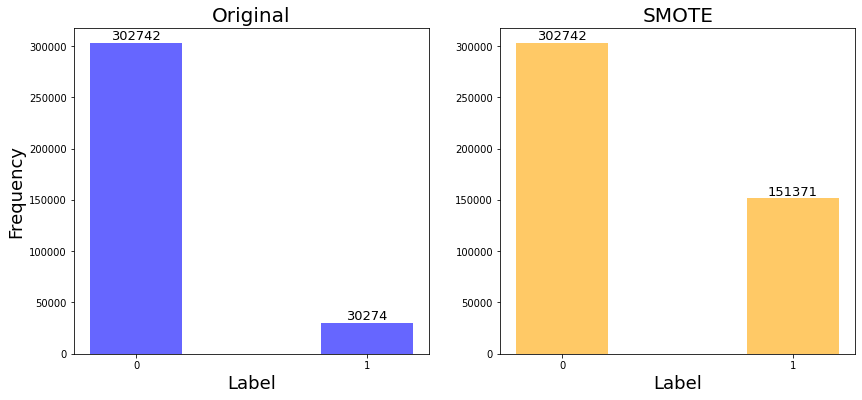

In [ ]:
plt.figure(figsize=(14, 6))
plt.subplot(121)

# Plot the bar graph for the original train
Y_fraud = list(y_train.value_counts())
Labels = ["0", "1"]

plot = plt.bar(Labels, Y_fraud, 
               width = 0.4,
              color = "blue",
              alpha = 0.6)
 
# Add the data value on head of the bar
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%d' % int(height), ha='center', va='bottom', 
             fontsize = 13)

# Add labels and title
plt.title("Original", fontsize = 20)
plt.xlabel("Label", fontsize = 18)
plt.ylabel("Frequency", fontsize = 18)


plt.subplot(122)

# Plot the bar graph for the over-sampled train
Y_fraud_smote = list(tr_y.value_counts())

plot_smote = plt.bar(Labels, Y_fraud_smote, 
               width = 0.4,
              color = "orange",
              alpha = 0.6)
 
# Add the data value on head of the bar
for value in plot_smote:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%d' % int(height), ha='center', va='bottom', 
             fontsize = 13)

# Add labels and title
plt.title("SMOTE", fontsize = 20)
plt.xlabel("Label", fontsize = 18)

# Display the graph on the screen
plt.show()

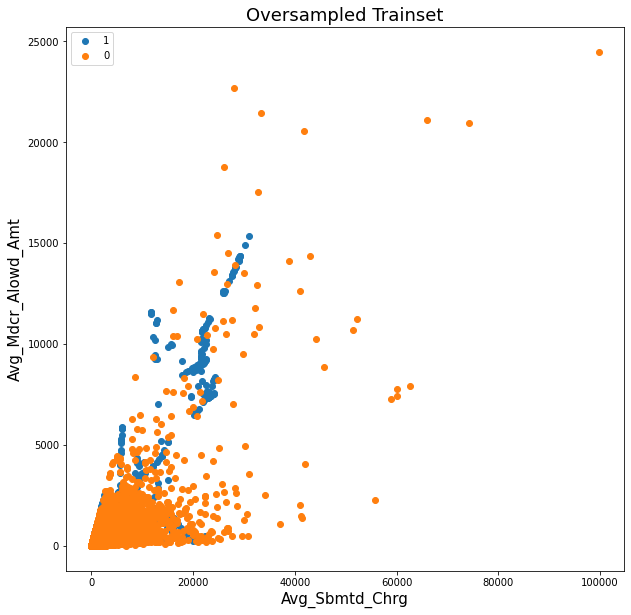

In [ ]:
# scatter plot of the data transformed by SMOTE 
# x-axis = "Tot_Benes_mean"
# y-axis = "Tot_Bene_Day_Srvcs_mean"

plt.figure(figsize=(10, 10))

counter = Counter(tr_y)
for label, _ in counter.items():
    row_ix = where(tr_y == label)[0]
    plt.scatter(tr_X.iloc[row_ix, 3], tr_X.iloc[row_ix, 4], label=str(label))

plt.title("Oversampled Trainset", fontsize = 18)
plt.xlabel("Avg_Sbmtd_Chrg", fontsize = 15)
plt.ylabel("Avg_Mdcr_Alowd_Amt", fontsize = 15)
plt.legend()
plt.show()

## Model Training 

### Data Partitioning (Train & Valid)

In [11]:
trans_tr_df = pd.concat([tr_X, tr_y], axis = 1)

In [14]:
# Split train and validation sets 
np.random.seed(SEED)

ratio = 0.8 # split train & validation sets with 7:3 ratio 

split = np.random.rand(len(trans_tr_df)) < ratio # define indices of 70% corresponding to the training set

train = trans_tr_df[split]
valid = trans_tr_df[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

Train data rows = 363675, columns = 10
Validation data rows = 90438, columns = 10


## PyCaret

In [12]:
trans_tr_df

,Type,Place_Of_Srvc,Tot_Benes,Tot_Srvcs,Tot_Bene_Day_Srvcs,Avg_Sbmtd_Chrg,Avg_Mdcr_Alowd_Amt,Avg_Mdcr_Pymt_Amt,Fraud
0,Optometry,1,12,12.000000,12,66.000000,30.146667,24.017500,1
1,Orthopedic Surgery,1,32,51.000000,51,140.000000,53.551373,38.991765,0
2,Podiatry,1,22,69.000000,69,100.000000,69.400725,53.272464,0
3,Family Practice,1,40,50.000000,50,30.000000,15.430000,15.430000,0
4,Diagnostic Radiology,1,61,62.000000,62,213.629032,120.259032,65.797581,0
...,...,...,...,...,...,...,...,...,...
454108,Ophthalmology,1,147,255.692779,255,128.006565,64.463305,46.706498,1
454109,Clinical Laboratory,0,34,38.369616,38,83.821704,48.867890,36.991454,1
454110,General Practice,1,37,50.802209,50,21.216652,2.959866,2.959866,1
454111,Neurology,0,13,15.481264,15,1494.164225,778.362439,620.158113,1


In [15]:
trans_tr_df

,Type,Place_Of_Srvc,Tot_Benes,Tot_Srvcs,Tot_Bene_Day_Srvcs,Avg_Sbmtd_Chrg,Avg_Mdcr_Alowd_Amt,Avg_Mdcr_Pymt_Amt,Fraud
0,Optometry,O,12,12.000000,12,66.000000,30.146667,24.017500,1
1,Orthopedic Surgery,O,32,51.000000,51,140.000000,53.551373,38.991765,0
2,Podiatry,O,22,69.000000,69,100.000000,69.400725,53.272464,0
3,Family Practice,O,40,50.000000,50,30.000000,15.430000,15.430000,0
4,Diagnostic Radiology,O,61,62.000000,62,213.629032,120.259032,65.797581,0
...,...,...,...,...,...,...,...,...,...
454108,Ophthalmology,O,147,255.692779,255,128.006565,64.463305,46.706498,1
454109,Clinical Laboratory,F,34,38.369616,38,83.821704,48.867890,36.991454,1
454110,General Practice,O,37,50.802209,50,21.216652,2.959866,2.959866,1
454111,Neurology,F,13,15.481264,15,1494.164225,778.362439,620.158113,1


In [16]:
train = setup(data = trans_tr_df, target = "Fraud")

,Description,Value
0,session_id,8748
1,Target,Fraud
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(454113, 9)"
5,Missing Values,0
6,Numeric Features,6
7,Categorical Features,2
8,Ordinal Features,0
9,High Cardinality Features,0


KeyError: 'dashboard_logger'

In [19]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8692,0.9277,0.7449,0.8441,0.7914,0.6967,0.6996,24.5340
et,Extra Trees Classifier,0.8642,0.9220,0.7386,0.8347,0.7837,0.6852,0.6880,34.1870
catboost,CatBoost Classifier,0.8489,0.9095,0.6494,0.8631,0.7411,0.6374,0.6503,12.2990
xgboost,Extreme Gradient Boosting,0.8240,0.8862,0.5839,0.8388,0.6885,0.5713,0.5895,42.1820
dt,Decision Tree Classifier,0.8142,0.7958,0.7408,0.7127,0.7264,0.5858,0.5861,3.2320
lightgbm,Light Gradient Boosting Machine,0.8120,0.8736,0.5454,0.8322,0.6590,0.5368,0.5597,1.4780
knn,K Neighbors Classifier,0.7838,0.8540,0.7460,0.6537,0.6968,0.5299,0.5327,3.8670
gbc,Gradient Boosting Classifier,0.7215,0.7670,0.2554,0.7357,0.3791,0.2505,0.3089,23.5870
ada,Ada Boost Classifier,0.7131,0.7314,0.2807,0.6643,0.3946,0.2452,0.2844,5.1770
ridge,Ridge Classifier,0.7109,0.0000,0.2933,0.6453,0.4033,0.2464,0.2798,0.2610


/opt/anaconda3/envs/pycaret_model_comp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/pycaret_model_comp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/pycaret_model_comp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/pycaret_model_comp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/ana

/opt/anaconda3/envs/pycaret_model_comp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/pycaret_model_comp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/pycaret_model_comp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/pycaret_model_comp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/ana

/opt/anaconda3/envs/pycaret_model_comp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/pycaret_model_comp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/pycaret_model_comp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/envs/pycaret_model_comp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/opt/ana

In [20]:
print(best)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=8748, verbose=0,
                       warm_start=False)


In [21]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [18]:
def max_f1(testset, res):
    pred_prob = model.predict_proba(testset[X_var])
    phat_df = pd.DataFrame([phat[1] for phat in pred_prob], columns = ["phat"])
    temp_df = pd.concat([testset[[y_var]].reset_index(drop=True), phat_df],axis=1)
    
    f1_df = pd.DataFrame(columns = ["cut", "f1_score"])
    
    for cut in np.arange(0, 1+res, res):
        temp_df["pred"] = np.where(temp_df["phat"] > cut, 1, 0)
        f1 = f1_score(temp_df["Fraud"], temp_df["pred"])
        f1_df = f1_df.append({"cut":cut, 
                              "f1_score":f1}, 
                             ignore_index=True)
        
    max_f1 = f1_df.loc[f1_df["f1_score"] == f1_df["f1_score"].max()]
    return max_f1

max_f1 = max_f1(te_df, 0.01)
max_f1

,cut,f1_score
42,0.42,0.391166


In [21]:
model.best_params_

{'depth': 7,
 'devices': '0:1',
 'eval_metric': 'F1',
 'iterations': 3000,
 'learning_rate': 0.1,
 'od_type': 'Iter',
 'od_wait': 500,
 'random_seed': 1234,
 'task_type': 'GPU',
 'verbose': 200}

In [16]:
best_params = {'depth': 7,
               'devices': '0:1',
               'eval_metric': 'F1',
               'iterations': 5000,
               'learning_rate': 0.1,
               'od_type': 'Iter',
               'od_wait': 500,
               'random_seed': 1234,
               'task_type': 'GPU',
               'verbose': 200}
best_cat = CatBoostClassifier(**best_params)
best_cat.fit(train[X_var], train[y_var], 
          cat_features = ["Type"],
          eval_set=(valid[X_var], valid[y_var]),
          use_best_model=True)

0:	learn: 0.3989934	test: 0.4052724	best: 0.4052724 (0)	total: 30.2ms	remaining: 2m 30s
200:	learn: 0.6603004	test: 0.6579764	best: 0.6579764 (200)	total: 5.63s	remaining: 2m 14s
400:	learn: 0.6979467	test: 0.6920769	best: 0.6921237 (399)	total: 11.2s	remaining: 2m 8s
600:	learn: 0.7202178	test: 0.7099595	best: 0.7100370 (598)	total: 16.8s	remaining: 2m 3s
800:	learn: 0.7353218	test: 0.7205112	best: 0.7205293 (793)	total: 22.4s	remaining: 1m 57s
1000:	learn: 0.7483020	test: 0.7296311	best: 0.7296311 (1000)	total: 28s	remaining: 1m 51s
1200:	learn: 0.7578678	test: 0.7362463	best: 0.7363628 (1199)	total: 33.6s	remaining: 1m 46s
1400:	learn: 0.7661938	test: 0.7419242	best: 0.7419870 (1398)	total: 39.2s	remaining: 1m 40s
1600:	learn: 0.7736655	test: 0.7471052	best: 0.7471462 (1599)	total: 44.9s	remaining: 1m 35s
1800:	learn: 0.7805588	test: 0.7516774	best: 0.7518375 (1791)	total: 50.5s	remaining: 1m 29s
2000:	learn: 0.7876706	test: 0.7553600	best: 0.7555685 (1998)	total: 56.1s	remaining: 1

In [18]:
def max_f1(testset, res):
    pred_prob = best_cat.predict_proba(testset[X_var])
    phat_df = pd.DataFrame([phat[1] for phat in pred_prob], columns = ["phat"])
    temp_df = pd.concat([testset[[y_var]].reset_index(drop=True), phat_df],axis=1)
    
    f1_df = pd.DataFrame(columns = ["cut", "f1_score"])
    
    for cut in np.arange(0, 1+res, res):
        temp_df["pred"] = np.where(temp_df["phat"] > cut, 1, 0)
        f1 = f1_score(temp_df["Fraud"], temp_df["pred"])
        f1_df = f1_df.append({"cut":cut, 
                              "f1_score":f1}, 
                             ignore_index=True)
        
    max_f1 = f1_df.loc[f1_df["f1_score"] == f1_df["f1_score"].max()]
    return max_f1

max_f1 = max_f1(te_df, 0.01)
max_f1

,cut,f1_score
37,0.37,0.390517


In [33]:
import shap
from catboost import Pool
shap_values = best_cat.get_feature_importance(Pool(te_df[X_var], label = y_test, cat_features = ["Type"]), 
                                                 type='ShapValues')

In [ ]:
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
shap.initjs()
shap.force_plot(expected_value, shap_values[0:], te_df[X_var].iloc[0:])

In [ ]:
shap_values[:,:-1]

array([[-0.27679471,  0.00501182, -0.10030114, ...,  0.07565451,
         0.0263282 ,  0.32600871],
       [-0.15042962,  0.29833129, -0.14709196, ...,  0.06408882,
         0.02708518, -0.25183884],
       [ 0.25504208, -1.20874882,  0.2952648 , ...,  0.06968892,
         0.02648236,  0.1467409 ],
       ...,
       [-0.08136786, -0.16704825, -0.14457482, ...,  0.06796119,
         0.02685951, -0.27616594],
       [ 0.08655711, -0.63933106,  0.09405157, ...,  0.07488803,
         0.02566137, -0.19404147],
       [-0.01937231, -0.39696042,  0.03279072, ...,  0.07189636,
         0.02519172,  0.15126236]])